## Reload

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [24]:
artists=pd.read_csv('../datasets/artists.csv')

G_geo_B_copy = nx.read_gexf("gexf/G_geo_B.gexf")
G_influencedby_B = nx.read_gexf("gexf/G_influencedby_B.gexf")
G_influencedon_B = nx.read_gexf("gexf/G_influencedon_B.gexf")
G_friendsandcoworkers_B_copy = nx.read_gexf("gexf/G_friendsandcoworkers_B.gexf")
G_influencedon_B_copy = nx.read_gexf("gexf/G_influencedon_B2.gexf")
G_artists_B = nx.read_gexf("gexf/G_artists_B.gexf")

## B2) Geographical analysis with time

The main attributes:

- place of birth
- places
- places by years
- nationality

In [ ]:
#Macros
birthplace_weight = 0.5; places_weight = 0.4; nationality_weight = 0.8
weights = [birthplace_weight,places_weight,nationality_weight]

year_index_threshold = 0
places_threshold = 1.5
styles_threshold = 0.3

In [ ]:
G_geo_B = nx.Graph(); G_geo_B_copy.add_nodes_from(artists['artist'])

In [ ]:
def year_index(years1, years2):
    #Year_index: years between first and last year are accounted with weight 1, years between birth and first year are accounted with weight 0.1.
    #For each overlapping year, we add 1 times the weights. Lastly, we divide by the total number of years of the younger artist.
    year_index = 0
    if(years1[0] > years2[0]):
        yearst = years1;years1 = years2;years2 = yearst
    #No overlap
    if(years1[2] < years2[0]):  #Not needed, but better for computation
        return 0
    for year in range((years1)[0], np.min([years1[2],years2[2]])+1):
        c = 1
        if year < years2[0]:
            c = 0
            continue
        if(year<years1[1]):
            c = c*0.2
        if(year<years2[1]):
            c = c*0.2
        year_index += c
    year_index = year_index/(np.min([years1[2]-years1[0],years2[2]-years2[0]])+1)
    return year_index

year_index([1970, 1990, 2040], [1980, 2000, 2010])

0.432258064516129

In [ ]:
Matisse_years1=[1869, 1890, 1954]
Picasso_years2=[1881, 1900, 1973]
year_index(Matisse_years1, Picasso_years2)

0.6669767441860465

In [ ]:
from geopy.geocoders import Nominatim    
geolocator = Nominatim(user_agent="PainterProject")

# Function to get the country from a birthplace
def get_country(birthplace):
    location = geolocator.geocode(birthplace)
    if location:
        return location.address.split(",")[-1].strip()
    return None

In [ ]:
def place_index(placescount1, placescount2, birthplace1, birthplace2, nationality1, nationality2):
    #Places index
    i1 = 0; i2 = 0
    if placescount1 is not np.nan and placescount2 is not np.nan:
        places1_count_tuple = [(x.split(":")[0], int(x.split(":")[1])) if ":" in x else (x, 0) for x in placescount1]
        places2_count_tuple = [(x.split(":")[0], int(x.split(":")[1])) if ":" in x else (x, 0) for x in placescount2]
        for tuple1 in places1_count_tuple:
            for tuple2 in places2_count_tuple:
                if(tuple1[0] == tuple2[0]):
                    i1 += tuple1[1]; i2 += tuple2[1]
        sum1 = np.sum([x[1] for x in places1_count_tuple]); sum2 = np.sum([x[1] for x in places2_count_tuple])
        i1 = i1/np.min([sum1,25]); i2 = i2/np.min([sum2,25]) #This allows the places to go over 1, as many paintings in one place suggests a strong connection
        i = np.max([i1,i2])
    else:
        i = 0
    n1 = 0; n2 = 0
    if type(nationality1) == float or type(nationality2) == float:
        n = 0 #One of them is a nan
    else:
        for nat1 in nationality1.split(','):
            for nat2 in nationality2.split(','):
                if(nat1 == nat2):
                    n1 += 1; n2 += 1
        n = n1*n2/len(nationality1.split(','))/len(nationality2.split(','))
    b = 1 if birthplace1 == birthplace2 else 0
        
    """
        #Note: this codes almost always times out.
        else:
        #If they are in the same country, we give a weight of 0.5
        try:
            b = 0.5 if get_country(birthplace1) == get_country(birthplace2) else 0
        except:
            b = 0; print("Error with birthplaces: ", birthplace1, birthplace2)
    """

    return weights[0]*b + weights[1]*i + weights[2]*n


Michelangelo_places_count = [x.replace("{","").replace("}","") for x in artists[artists['artist'] == "Michelangelo"]["PlacesCount"].iloc[0].split(",") if x != '']
Picasso_places_count = [x.replace("{","").replace("}","") for x in artists[artists['artist'] == "Pablo Picasso"]["PlacesCount"].iloc[0].split(",")]
place_index(Michelangelo_places_count, Picasso_places_count, "Caprese", "Malaga", artists[artists['artist'] == "Michelangelo"]["Nationality"].iloc[0], artists[artists['artist'] == "Michelangelo"]["Nationality"].iloc[0])

5.856000000000001

In [ ]:
def style_index(styles_count1, styles_count2, threshold=100):
    """
    Calculate a style index based on the overlap of styles between two lists.

    Parameters:
    - styles_count1: List of tuples containing styles and their counts for artist 1.
    - styles_count2: List of tuples containing styles and their counts for artist 2.
    - threshold: Minimum count of shared artworks in a style for a connection to be considered.

    Returns:
    - Style index between 0 and 1.
    """

    # Styles index
    i1 = 0
    i2 = 0

    if styles_count1 and styles_count2:
        for style1, count1 in styles_count1:
            for style2, count2 in styles_count2:
                if style1 == style2:
                    i1 += count1
                    i2 += count2

        sum1 = np.sum([count for _, count in styles_count1])
        sum2 = np.sum([count for _, count in styles_count2])

        i1 = i1 / np.min([sum1, threshold])
        i2 = i2 / np.min([sum2, threshold])

        # This allows the styles to go over 1, as many artworks in one style suggests a strong connection
        styles_index = np.max([i1, i2])
    else:
        styles_index = 0

    return styles_index

In [ ]:
combined_index_threshold = 0.4
for i in range(len(artists['artist'])):
    artist1 = artists['artist'].iloc[i]
    geo_data1 = artists[artists['artist']==artist1].reset_index().loc[0][['birth_place','Nationality','Places', 'PlacesYears','PlacesCount','PaintingSchool','birth_year', 'FirstYear','LastYear']]
    years1 = [geo_data1['birth_year'], geo_data1['FirstYear'], geo_data1['LastYear']]
    if (np.isnan(years1[0])) or (np.isnan(years1[1])) or (np.isnan(years1[2])):
        continue
    for j in range(i+1, len(artists['artist'])):
        artist2 = artists['artist'].iloc[j]
        geo_data2 = artists[artists['artist']==artist2].reset_index().loc[0][['birth_place','Nationality','Places', 'PlacesYears','PlacesCount','PaintingSchool','birth_year', 'FirstYear','LastYear']]
        years2 = [geo_data2['birth_year'], geo_data2['FirstYear'], geo_data2['LastYear']]
        if (np.isnan(years2[0])) or (np.isnan(years2[1])) or (np.isnan(years2[2])):
            continue
        #Year index
        year_index_val = year_index([int(year) for year in years1], [int(year) for year in years2])
        #Place index
        places1 = geo_data1["PlacesCount"]; places2 = geo_data2["PlacesCount"]
        if((places1 is not np.nan) & (places2 is not np.nan)):
            places1m = [x.replace("{","").replace("}","") for x in places1.split(",") if x != '']
            places2m = [x.replace("{","").replace("}","") for x in places2.split(",") if x != '']
        else:
            places1m = np.nan; places2m = np.nan
        birthplace1 = geo_data1["birth_place"]; birthplace2 = geo_data2["birth_place"]
        nationality1= geo_data1['Nationality']; nationality2 = geo_data2['Nationality']
        place_index_val = place_index(places1m, places2m, birthplace1, birthplace2, nationality1, nationality2)
        if (year_index_val > year_index_threshold) and (place_index_val > places_threshold) and (place_index_val*year_index_val > combined_index_threshold):
            G_geo_B.add_edge(artist1, artist2, weight=year_index_val*place_index_val)

G_geo_B_filtered = G_geo_B.copy()
G_geo_B_filtered.remove_nodes_from(list(nx.isolates(G_geo_B_filtered)))

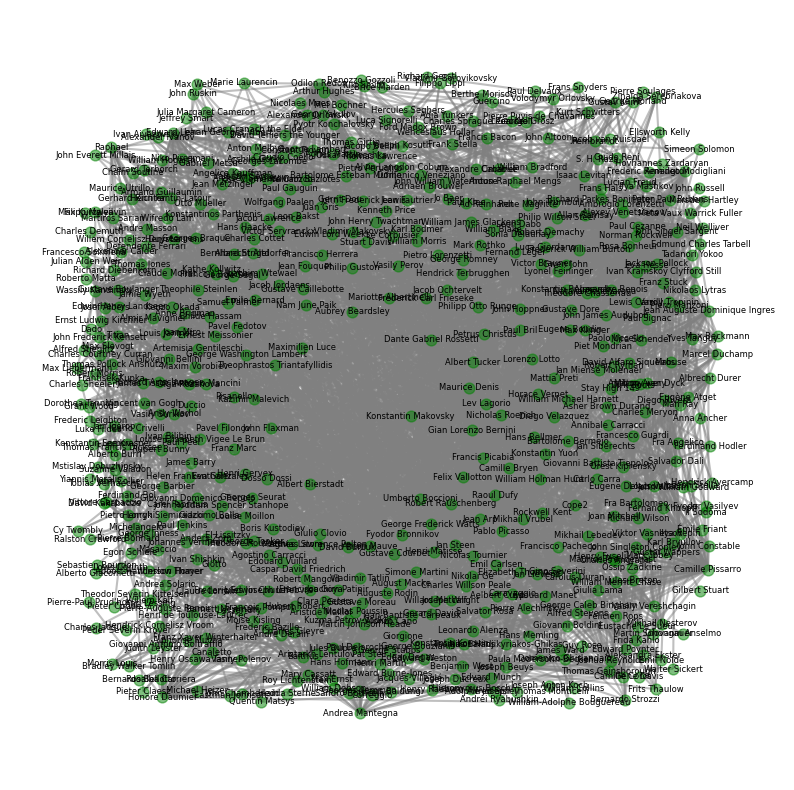

In [ ]:
#Plot G_geo_B_filtered
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_geo_B_filtered, k=0.9, iterations=2)
nx.draw_networkx_edges(G_geo_B_filtered, pos, width=1.5, alpha=0.5, edge_color='grey')
nx.draw_networkx_nodes(G_geo_B_filtered, pos, node_size=60, node_color='green', alpha=0.5)
nx.draw_networkx_labels(G_geo_B_filtered, pos, font_size=6, font_family='sans-serif', font_color='black',)
plt.axis('off')
plt.show()


Gephi drawing:

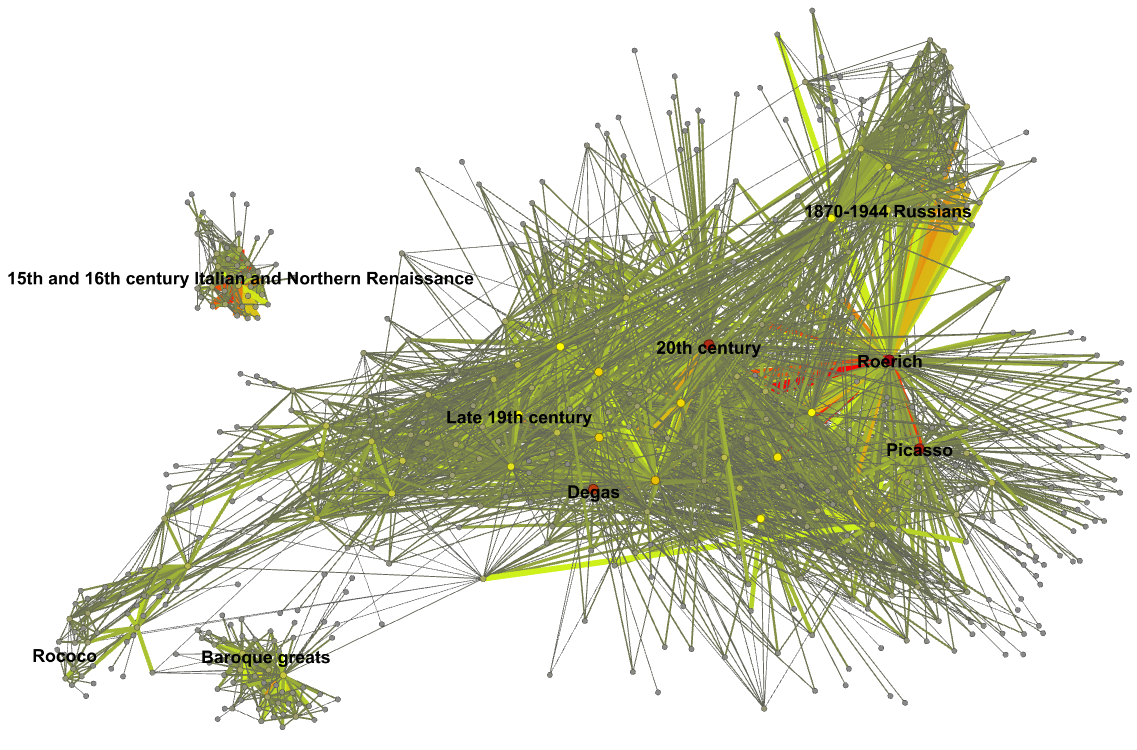

In [ ]:
#Save graph to Gephi
nx.write_gexf(G_geo_B_filtered, "gexf/G_geo_B.gexf")

## Reload

In [2]:
G_geo_B_filtered = nx.read_gexf("gexf/G_geo_B.gexf")

Most common style mapped:

In [87]:
nationality_mapping = {
    'French': 'France',
    'German': 'Germany',
    'Dutch': 'Netherlands',
    'Italian': 'Italy',
    'Spanish': 'Spain',
    'British': 'United Kingdom',
    'Portuguese': 'Portugal',
    'Swiss': 'Switzerland',
    'Swedish': 'Sweden',
    'Norwegian': 'Norway',
    'Danish': 'Denmark',
    'Finnish': 'Finland',
    'Greek': 'Greece',
    'Belgian': 'Belgium',
    'Austrian': 'Austria',
    'Polish': 'Poland',
    'Czech': 'Czechia',
    'Hungarian': 'Hungary',
    'Romanian': 'Romania',
    'Bulgarian': 'Bulgaria',
    'Croatian': 'Croatia',
    'Serbian': 'Serbia',
    'Slovak': 'Slovakia',
    'Slovenian': 'Slovenia',
    'Bosnian': 'Bosnia and Herz.',
    'Montenegrin': 'Montenegro',
    'Macedonian': 'North Macedonia',
    'Belarusian': 'Belarus',
    'Latvian': 'Latvia',
    'Lithuanian': 'Lithuania',
    'Estonian': 'Estonia',
    'Albanian': 'Albania',
    'Kosovar': 'Kosovo',
    'Turkish': 'Turkey',
    'Icelandic': 'Iceland',
    'Irish': 'Ireland',
    'Scottish': 'Scotland',
    'Welsh': 'Wales',
    'American': 'United States',
    'Russian': 'Russia',
    'Ukrainian': 'Ukraine',
    'Chinese': 'China',
    'Japanese': 'Japan',
    # Add more as needed
}


In [88]:
def map_nationalities(nationality_str):
    if type(nationality_str)==float:
        return np.nan
    nationalities = nationality_str.split(',')
    countries = [nationality_mapping.get(nat.strip(), nat.strip()) for nat in nationalities]
    return ', '.join(countries)

artists['Country'] = artists['Nationality'].apply(map_nationalities)

In [89]:
wikiart = pd.read_csv('../datasets/wikiart_artists_styles_grouped.csv')
#Remove artists that are not in the artists dataset
wikiart = wikiart[wikiart['artist'].isin(artists['artist'])].reset_index(drop=True)
#For each row, search the artist in the artists dataset and get the country
wikiart['Countries'] = wikiart['artist'].apply(lambda x: artists[artists['artist']==x]['Country'].iloc[0] if x in artists['artist'].values else np.nan)
wikiart = wikiart[wikiart['style']!="Unknown"].reset_index(drop=True)
wikiart

,style,artist,movement,count,Countries
0,Abstract Art,Ad Reinhardt,Abstract Expressionism,15,United States
1,Abstract Art,Adnan Coker,Abstract Art,25,Turkey
2,Abstract Art,Akkitham Narayanan,Abstract Art,17,Indian
3,Abstract Art,Alberto Magnelli,Abstract Art,19,"Italy, France"
4,Abstract Art,Alekos Kontopoulos,Social Realism,26,Greece
...,...,...,...,...,...
5294,Verism,Julius Bissier,Art Informel,4,Germany
5295,Verism,Max Beckmann,Expressionism,6,Germany
5296,Yoruba,Olowe of Ise,Native Art,13,NaN
5297,Zen,Jiro Yoshihara,Art Informel,2,Japan


In [90]:
plotted_countries= ['France',
    'Germany',
    'Netherlands',
    'Italy',
    'Spain',
    'United Kingdom',
    'Portugal',
    'Switzerland',
    'Sweden',
    'Norway',
    'Denmark',
    'Finland',
    'Greece',
    'Belgium',
    'Austria',
    'Poland',
    'Czechia',
    'Hungary',
    'Romania',
    'Bulgaria',
    'Croatia',
    'Serbia',
    'Slovakia',
    'Slovenia',
    'North Macedonia',
    'Latvia',
    'Lithuania',
    'Iceland',
    'Ireland',
    'Russia',
    'Ukraine',
]

In [91]:
#Wikiart: for each country, get the most common style
most_popular_styles = wikiart.groupby('Countries')['style'].agg(lambda x: x.mode().iloc[0] if not x.empty else None).reset_index()
#Drop country if it is not in the nationality_mapping dictionary
most_popular_styles= most_popular_styles[most_popular_styles['Countries'].isin(plotted_countries)]
most_popular_styles['style'].value_counts()

style
Impressionism              10
Expressionism               7
Art Nouveau (Modern)        2
Abstract Art                2
Realism                     2
Surrealism                  2
High Renaissance            1
Constructivism              1
Baroque                     1
Naïve Art (Primitivism)     1
Socialist Realism           1
Romanticism                 1
Name: count, dtype: int64

Colors:

C:\Users\hanic\AppData\Local\Temp\ipykernel_1660\4152264459.py:25: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


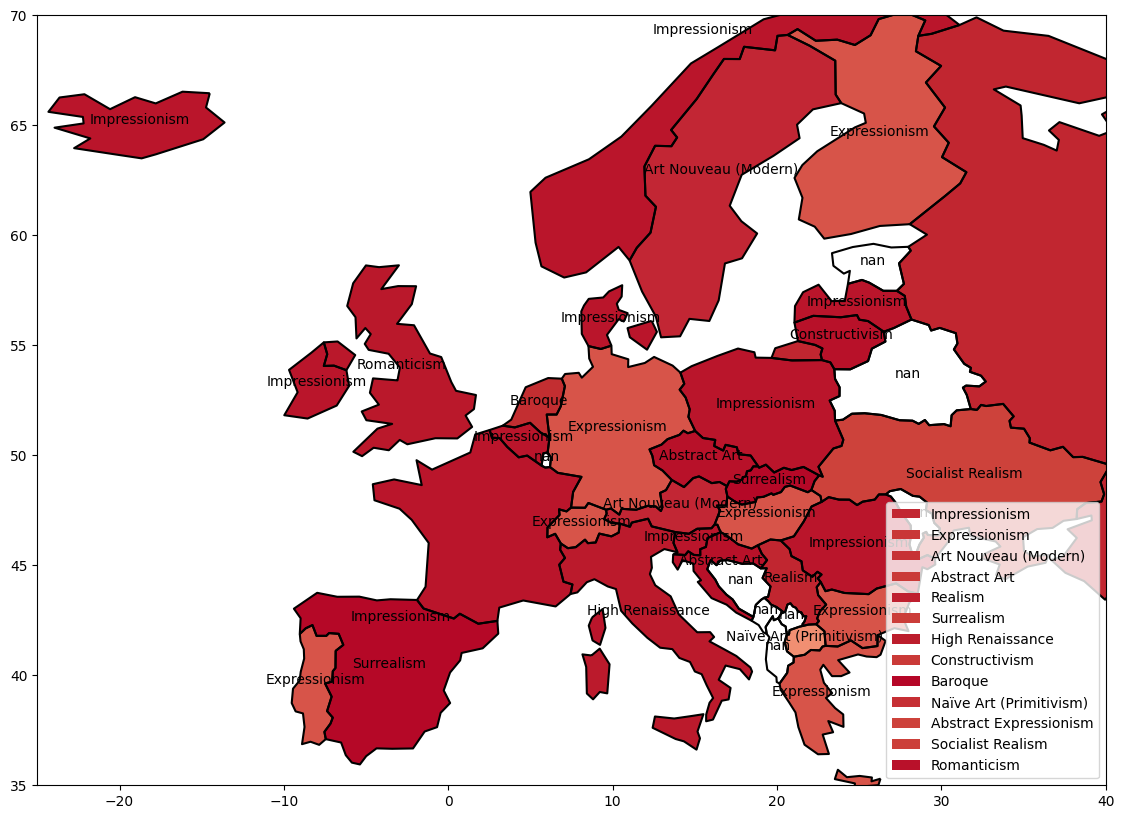

In [99]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

style_age = {
    'Impressionism': 1860,
    'Expressionism': 1905,
    'Art Nouveau (Modern)': 1890,
    'Abstract Art': 1910,
    'Realism': 1840,
    'Surrealism': 1920,
    'High Renaissance': 1490,
    'Constructivism': 1913,
    'Baroque': 1600,
    'Naïve Art (Primitivism)': 1880,
    'Abstract Expressionism': 1940,
    'Socialist Realism': 1930,
    'Romanticism': 1800
}

# Create a more colorful colormap based on style_age
cmap = LinearSegmentedColormap.from_list("StyleAge", [plt.cm.coolwarm(age / max(style_age.values())) for style, age in style_age.items()])

# Assuming you have a world shapefile named 'world.shp'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for only European countries
europe = world[(world['continent'] == 'Europe')]

# Merge Europe data with most_popular_styles
europe = europe.merge(most_popular_styles, how='left', left_on='name', right_on='Countries')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the boundaries
europe.boundary.plot(ax=ax, color='black')

# Plot the countries, colored by style
europe['style_color'] = europe['style'].map({style: cmap(age / max(style_age.values())) for style, age in style_age.items()})
europe.plot(column='style_color', ax=ax, legend=True, cmap=cmap)

# Annotate the countries with their style
europe.apply(lambda x: ax.annotate(text=x.style, xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

# Set x and y limits to zoom in on Europe
ax.set_xlim(-25, 40)
ax.set_ylim(35, 70)

# Create a custom legend
handles = []
labels = []
for style, age in style_age.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, fc=cmap(age / max(style_age.values()))))
    labels.append(style)
ax.legend(handles, labels, loc='lower right')

plt.show()


In [ ]:
style_color = {
    'Impressionism': 'red',
    'Expressionism': 'orange',
    'Art Nouveau (Modern)': 'yellow',
    'Abstract Art': 'green',
    'Realism': 'blue',
    'Surrealism': 'purple',
    'High Renaissance': 'pink',
    'Constructivism': 'brown',
    'Baroque': 'olive',
    'Naïve Art (Primitivism)': 'cyan',
    'Abstract Expressionism': 'magenta',
    'Socialist Realism': 'gray',
    'Romanticism': 'lime'
}

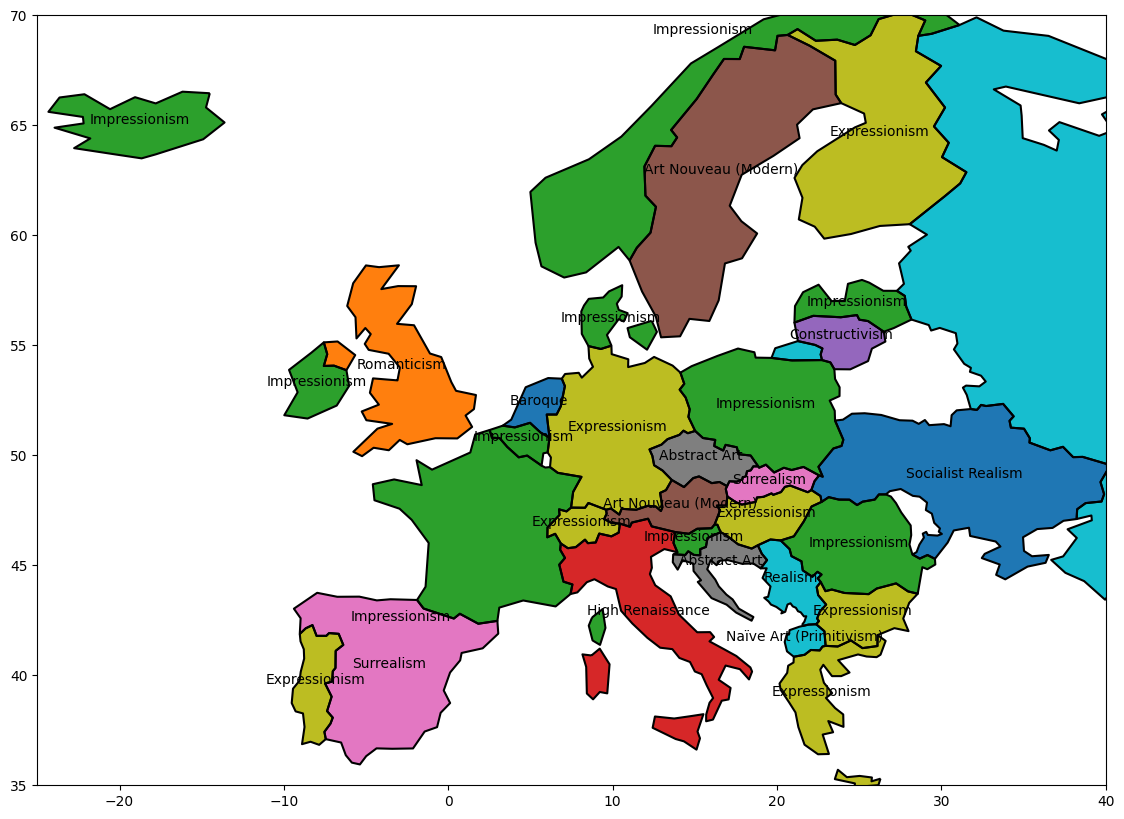

In [136]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have a GeoDataFrame named 'europe' with a 'style_color' column
# containing the RGBA values for each country's style

# Generate a random colormap with red-blue colors
cmap = sns.color_palette("RdBu", n_colors=len(europe["style"].unique()))

# Shuffle the colormap to ensure random assignment to styles
np.random.shuffle(cmap)

# Map style names to colors
style_colors = dict(zip(europe["style"].unique(), cmap))

# Map style names to their corresponding color in the DataFrame
europe["style_color"] = europe["style"].map(style_colors)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the boundaries
europe.boundary.plot(ax=ax, color='black')

# Plot the countries, colored by style_color
europe.plot(column='style_color', ax=ax, legend=False)

# Annotate the countries with their style
europe.apply(lambda x: ax.annotate(text=x.style, xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

# Set x and y limits to zoom in on Europe
ax.set_xlim(-25, 40)
ax.set_ylim(35, 70)



plt.show()


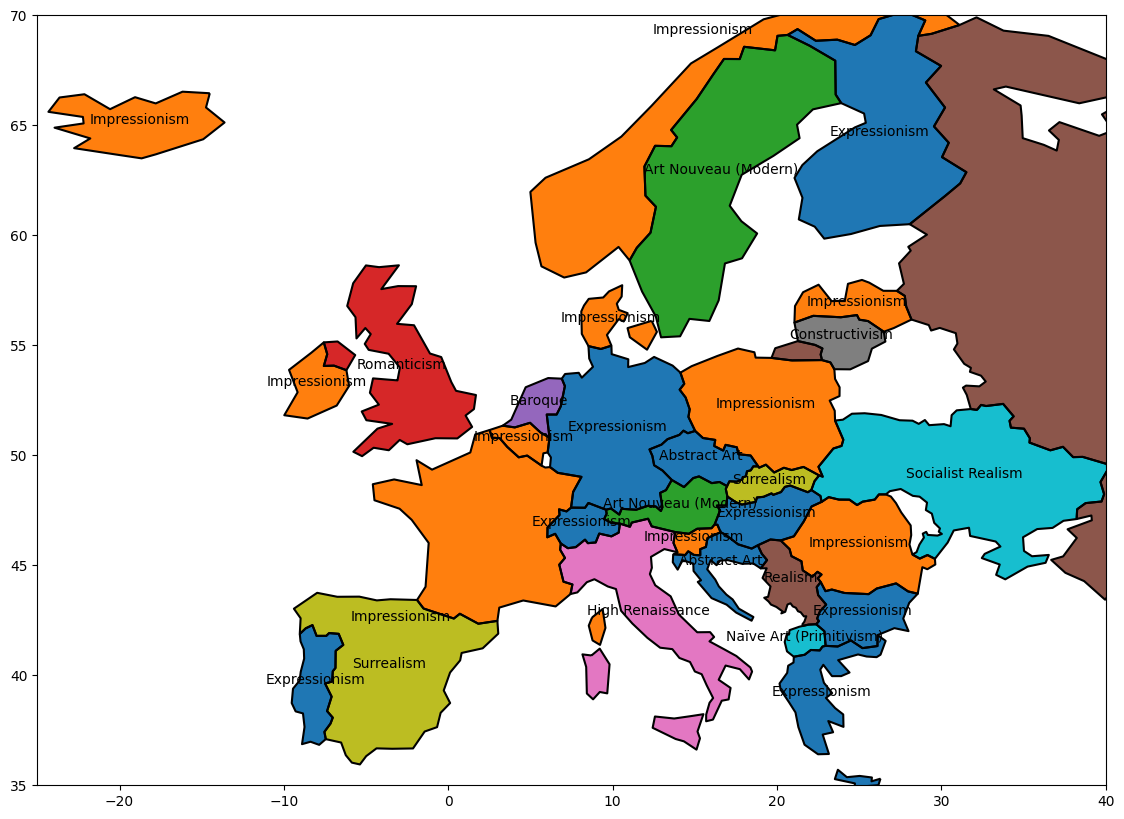